In [1]:
from google import genai
from google.genai import types

from IPython.display import Markdown, HTML, display

genai.__version__

'1.49.0'

In [3]:
from dotenv import load_dotenv
import os

# loads variables from .env
load_dotenv()

True

In [7]:
GOOGLE_API_KEY = os.getenv("GOOGLE_API_KEY")

if GOOGLE_API_KEY is None:
    raise ValueError("Environment variable GOOGLE_API_KEY not found!")

print("Secret loaded successfully!")

Secret loaded successfully!


In [9]:
client = genai.Client(api_key=GOOGLE_API_KEY)

In [11]:
# Define a retry policy. The model might make multiple consecutive calls automatically
# for a complex query, this ensures the client retries if it hits quota limits.
from google.api_core import retry

is_retriable = lambda e: (isinstance(e, genai.errors.APIError) and e.code in {429, 503})

if not hasattr(genai.models.Models.generate_content, '__wrapped__'):
  genai.models.Models.generate_content = retry.Retry(
      predicate=is_retriable)(genai.models.Models.generate_content)

## Use search grounding

### Model support

Search grounding is available in a limited set of models. Find a model that supports it on [the models page](https://ai.google.dev/gemini-api/docs/models/gemini).

In this guide, you'll use `gemini-2.0-flash`.

### Make a request

To enable search grounding, you specify it as a tool: `google_search`. Like other tools, this is supplied as a parameter in `GenerateContentConfig`, and can be passed to `generate_content` calls as well as `chats.create` (for all chat turns) or `chat.send_message` (for specific turns).


<table align=left>
  <td>
    <a target="_blank" href="https://aistudio.google.com/app/prompts/1GTkO-gH4vd6G7LpBJ6Ay7U1OaJer7yDD">Open in AI Studio</a>
  </td>
</table>

In [26]:
# Ask for information without search grounding.
response = client.models.generate_content(
    model='gemini-2.0-flash',
    contents="When and where is Kraftwerk next concert in Berlin?")

Markdown(response.text)

As of today, October 26, 2023, Kraftwerk does not have any upcoming concerts scheduled in Berlin. You can check their official website or other online ticket providers for any updates on their future concert dates.


In [28]:
# Now try with grounding enabled
# And now re-run the same query with search grounding enabled.
config_with_search = types.GenerateContentConfig(
    tools=[types.Tool(google_search=types.GoogleSearch())],
)

def query_with_grounding():
    response = client.models.generate_content(
        model='gemini-2.0-flash',
        contents="When and where is Kraftwerk next concert in Berlin?",
        config=config_with_search,
    )
    return response.candidates[0]


rc = query_with_grounding()
Markdown(rc.content.parts[0].text)

Kraftwerk will be performing at the Uber Eats Music Hall in Berlin on December 9 and 10, 2025, at 8:00 PM. The address of the venue is Uber Platz 2, 10243 Berlin-Friedrichshain.


### Response metadata

When search grounding is used, the model returns extra metadata that includes links to search suggestions, supporting documents and information on how the supporting documents were used.

Each "grounding chunk" represents information retrieved from Google Search that was used in the grounded generation request. Following the URI will take you to the source.

In [30]:
while not rc.grounding_metadata.grounding_supports or not rc.grounding_metadata.grounding_chunks:
    # If incomplete grounding data was returned, retry.
    rc = query_with_grounding()

chunks = rc.grounding_metadata.grounding_chunks
for chunk in chunks:
    print(f'{chunk.web.title}: {chunk.web.uri}')

visitberlin.de: https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQGHpK19-pdBbxTCyZ-x5XleUkpP0UoR5oE5sKp9WN2Ooj_EEphw8O76-mHfO1kOUzLDsSRSzkvxNTPufotkldYUx_QQxNOMg-gtjKXJ3R3CVFywZqn_C01RdJd9S_FMHYnnLmGaB34xPmakY3JNJ_EkCFLd7od2iF9xhfWM
uber-eats-music-hall.de: https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQG7YIn2bAfeWDGMQWz5ZFHvqJPvNorWLIKOCRb5DAk0LXCU_DROjWEz3b0TclYz2TPa6GZ7ftJatpHUllBYEWD8SkBQiQ3rI5vW1SqKmtedKXH8DuYbwAwRvVOVGsjOdcvOT8K4GcdR4k1LKwrRq5P7sgkz4IxXK1o=
berlin.de: https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQEtM7h-p1eLD7jwpaYdcYGpfWyXSSMd6uNtZwRZJVrocnnjk65wt98Q8qzsRgwMDBAoSSpoVVKD6zMXSxkBPpea1WgyTg1GKUXbhMjrrN8m0xl6p_x9yyf6EEYaD-T1sYGBrmlOiCn6J-Sx5-Xda-p7PispSrSJUt8ttbI8OHhC7s42GSaPZl62rL74DzKGXyXdHrqeLnpLOTml2Nrg6h6UTwDhDpp3R6I=
eventim.de: https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQEFduF3KgfM0-pBIz5mCnWQwlMqaaNv3CdVvYqYRLFBx1Fc9o9N0cIhgfSY0elLeCWLL6p-V0BoVtFBZNYqhweQGeaHWQbGIJFfmnISa

In [32]:
HTML(rc.grounding_metadata.search_entry_point.rendered_content)

In [34]:
from pprint import pprint

supports = rc.grounding_metadata.grounding_supports
for support in supports:
    pprint(support.to_json_dict())

{'confidence_scores': [0.0052200262,
                       0.011276638,
                       0.67859095,
                       0.6390036,
                       0.70160204],
 'grounding_chunk_indices': [0, 1, 2, 3, 4],
 'segment': {'end_index': 105,
             'text': 'Kraftwerk will be performing at the Uber Eats Music Hall '
                     'in Berlin on December 9 and 10, 2025, at 8:00 PM'}}
{'confidence_scores': [0.9490651],
 'grounding_chunk_indices': [2],
 'segment': {'end_index': 176,
             'start_index': 107,
             'text': 'The address of the venue is Uber Platz 2, 10243 '
                     'Berlin-Friedrichshain'}}


In [36]:
import io

markdown_buffer = io.StringIO()

# Print the text with footnote markers.
markdown_buffer.write("Supported text:\n\n")
for support in supports:
    markdown_buffer.write(" * ")
    markdown_buffer.write(
        rc.content.parts[0].text[support.segment.start_index : support.segment.end_index]
    )

    for i in support.grounding_chunk_indices:
        chunk = chunks[i].web
        markdown_buffer.write(f"<sup>[{i+1}]</sup>")

    markdown_buffer.write("\n\n")


# And print the footnotes.
markdown_buffer.write("Citations:\n\n")
for i, chunk in enumerate(chunks, start=1):
    markdown_buffer.write(f"{i}. [{chunk.web.title}]({chunk.web.uri})\n")


Markdown(markdown_buffer.getvalue())

Supported text:

 * Kraftwerk will be performing at the Uber Eats Music Hall in Berlin on December 9 and 10, 2025, at 8:00 PM<sup>[1]</sup><sup>[2]</sup><sup>[3]</sup><sup>[4]</sup><sup>[5]</sup>

 * The address of the venue is Uber Platz 2, 10243 Berlin-Friedrichshain<sup>[3]</sup>

Citations:

1. [visitberlin.de](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQGHpK19-pdBbxTCyZ-x5XleUkpP0UoR5oE5sKp9WN2Ooj_EEphw8O76-mHfO1kOUzLDsSRSzkvxNTPufotkldYUx_QQxNOMg-gtjKXJ3R3CVFywZqn_C01RdJd9S_FMHYnnLmGaB34xPmakY3JNJ_EkCFLd7od2iF9xhfWM)
2. [uber-eats-music-hall.de](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQG7YIn2bAfeWDGMQWz5ZFHvqJPvNorWLIKOCRb5DAk0LXCU_DROjWEz3b0TclYz2TPa6GZ7ftJatpHUllBYEWD8SkBQiQ3rI5vW1SqKmtedKXH8DuYbwAwRvVOVGsjOdcvOT8K4GcdR4k1LKwrRq5P7sgkz4IxXK1o=)
3. [berlin.de](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQEtM7h-p1eLD7jwpaYdcYGpfWyXSSMd6uNtZwRZJVrocnnjk65wt98Q8qzsRgwMDBAoSSpoVVKD6zMXSxkBPpea1WgyTg1GKUXbhMjrrN8m0xl6p_x9yyf6EEYaD-T1sYGBrmlOiCn6J-Sx5-Xda-p7PispSrSJUt8ttbI8OHhC7s42GSaPZl62rL74DzKGXyXdHrqeLnpLOTml2Nrg6h6UTwDhDpp3R6I=)
4. [eventim.de](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQEFduF3KgfM0-pBIz5mCnWQwlMqaaNv3CdVvYqYRLFBx1Fc9o9N0cIhgfSY0elLeCWLL6p-V0BoVtFBZNYqhweQGeaHWQbGIJFfmnISagG6oj5To5345Fn89ym8RdSj1i9YJIlYQERKXQ-8iQ-CouzbJtXNder8aOiZ0ABkJE8kQqL1rjLXhNWBog4_jydeNZy-zz8dIefU)
5. [hellotickets.ie](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQFVXREFAWMBYi9U5Ksj5kGp9IryBB8Os-nokOMA1qNnIpJp9LB7-VuvASqx3tN7ZhGxNJWzja974PTwXkRJVzEc8AUfOQCqz8_-146-zRYZbjBTm-KVLegcmwbOnhwmd7KiJn42HxxAmG5I1FNWvMZJFVscdPcuCqLEPi3UkSzzTAzLwDky_w==)


## Search with tools

In this example, you'll use enable the Google Search grounding tool and the code generation tool across two steps. In the first step, the model will use Google Search to find the requested information and then in the follow-up question, it generates code to plot the results.

This usage includes textual, visual and code parts, so first define a function to help visualise these.

In [39]:
from IPython.display import display, Image, Markdown

def show_response(response):
    for p in response.candidates[0].content.parts:
        if p.text:
            display(Markdown(p.text))
        elif p.inline_data:
            display(Image(p.inline_data.data))
        else:
            print(p.to_json_dict())
    
        display(Markdown('----'))

In [41]:
config_with_search = types.GenerateContentConfig(
    tools=[types.Tool(google_search=types.GoogleSearch())],
    temperature=0.0,
)

chat = client.chats.create(model='gemini-2.0-flash')

response = chat.send_message(
    message="What were the medal tallies, by top-10 countries, for the 2024 olympics?",
    config=config_with_search,
)

show_response(response)

Here's the medal tally for the top 10 countries at the 2024 Paris Olympics:

1.  **United States:** 40 Gold, 44 Silver, 42 Bronze, 126 Total
2.  **China:** 40 Gold, 27 Silver, 24 Bronze, 91 Total
3.  **Great Britain:** 14 Gold, 22 Silver, 29 Bronze, 65 Total
4.  **France:** 16 Gold, 26 Silver, 22 Bronze, 64 Total
5.  **Australia:** 18 Gold, 19 Silver, 16 Bronze, 53 Total
6.  **Japan:** 20 Gold, 12 Silver, 13 Bronze, 45 Total
7.  **Italy:** 12 Gold, 13 Silver, 15 Bronze, 40 Total
8.  **Netherlands:** 15 Gold, 7 Silver, 12 Bronze, 34 Total
9.  **Germany:** 12 Gold, 13 Silver, 8 Bronze, 33 Total
10. **South Korea:** 13 Gold, 9 Silver, 10 Bronze, 32 Total



----

Continuing the chat, now ask the model to convert the data into a chart. The `code_execution` tool is able to generate code to draw charts, execute that code and return the image. You can see the executed code in the `executable_code` part of the response.

Combining results from Google Search with tools like live plotting can enable very powerful use cases that require very little code to run.

Okay, I can help you visualize this data using a Seaborn chart. I'll create a bar chart showing the medal distribution for each of the top 10 countries.



----

{'executable_code': {'code': "import pandas as pd\nimport seaborn as sns\nimport matplotlib.pyplot as plt\n\n# Data from the previous response\ndata = {\n    'Country': ['United States', 'China', 'Great Britain', 'France', 'Australia', 'Japan', 'Italy', 'Netherlands', 'Germany', 'South Korea'],\n    'Gold': [40, 40, 14, 16, 18, 20, 12, 15, 12, 13],\n    'Silver': [44, 27, 22, 26, 19, 12, 13, 7, 13, 9],\n    'Bronze': [42, 24, 29, 22, 16, 13, 15, 12, 8, 10],\n    'Total': [126, 91, 65, 64, 53, 45, 40, 34, 33, 32]\n}\n\ndf = pd.DataFrame(data)\n\n# Melt the dataframe to make it suitable for Seaborn\ndf_melted = df.melt(id_vars='Country', value_vars=['Gold', 'Silver', 'Bronze'], var_name='Medal', value_name='Count')\n\n# Create the bar chart\nplt.figure(figsize=(12, 8))\nsns.barplot(x='Country', y='Count', hue='Medal', data=df_melted, palette=['#FFD700', '#C0C0C0', '#CD7F32']) # Gold, Silver, Bronze colors\nplt.title('2024 Olympics Medal Tally (Top 10 Countries)')\nplt.xlabel('Country')\n

----

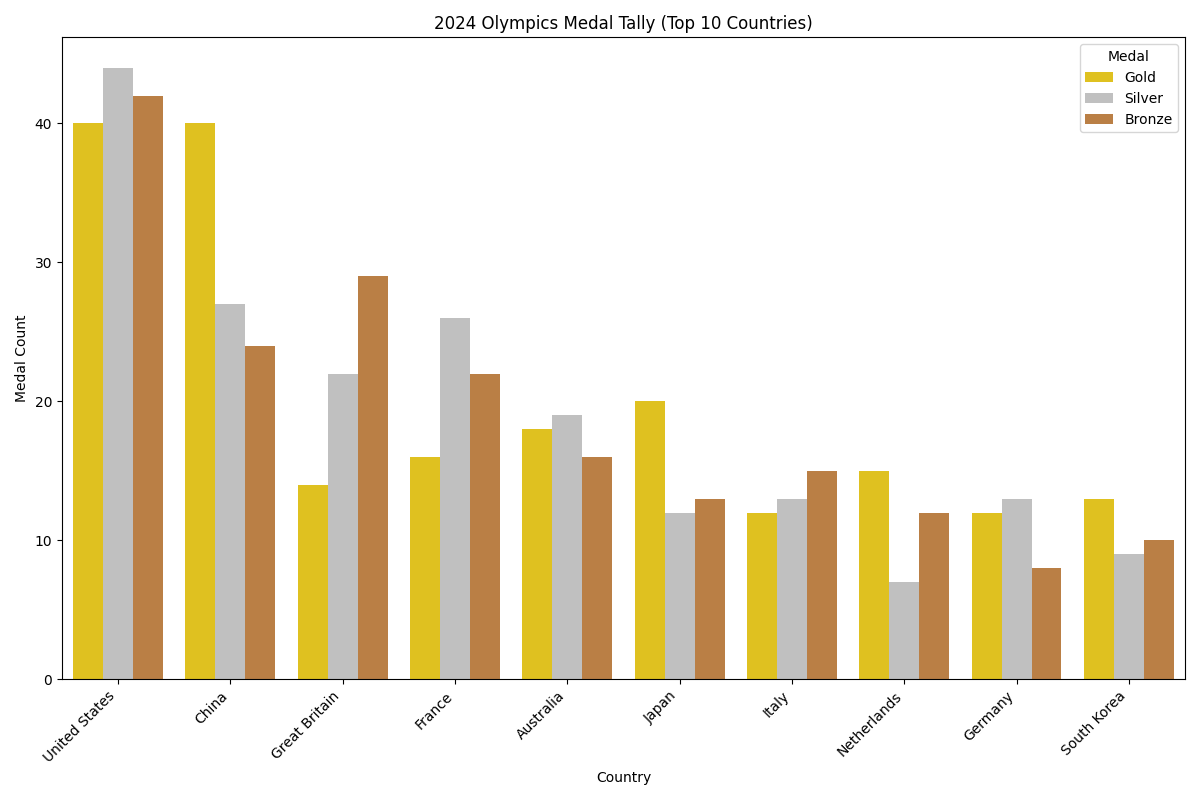

----

The bar chart visualizes the medal distribution (Gold, Silver, and Bronze) for each of the top 10 countries in the 2024 Olympics. The x-axis represents the countries, and the y-axis represents the medal count. Each country has three bars representing the number of Gold, Silver, and Bronze medals they won, with the bars colored accordingly. This allows for easy comparison of medal types between countries.


----

In [44]:
config_with_code = types.GenerateContentConfig(
    tools=[types.Tool(code_execution=types.ToolCodeExecution())],
    temperature=0.0,
)

response = chat.send_message(
    message="Now plot this as a seaborn chart. Break out the medals too.",
    config=config_with_code,
)

show_response(response)

## Further reading

When using search grounding, there are some specific requirements that you must follow, including when and how to show search suggestions, and how to use the grounding links.  Be sure to read and follow the details in the [search grounding capability guide](https://ai.google.dev/gemini-api/docs/grounding) and the [search suggestions guide](https://ai.google.dev/gemini-api/docs/grounding/search-suggestions).

Also check out some more compelling examples of using search grounding with the Live API in the [cookbook](https://github.com/google-gemini/cookbook/), like [this example that uses Google Maps to plot Search results on a map](https://github.com/google-gemini/cookbook/blob/main/examples/LiveAPI_plotting_and_mapping.ipynb) in an audio conversation, or [this example](https://github.com/google-gemini/cookbook/blob/main/examples/Search_grounding_for_research_report.ipynb) that builds a comprehensive research report.

*- [Mark McD](https://linktr.ee/markmcd)*